# Module 07 Lab - Better Model Evaluation

**Objective:** To move beyond simple accuracy and learn how to use more sophisticated and reliable evaluation techniques, including the confusion matrix, precision, recall, and cross-validation.

**In this lab, you will write the code to generate and interpret these advanced evaluation metrics.**

## Part 1: Setup and Model Training

Let's first train a model so we have something to evaluate. We will use the Titanic dataset again to predict survival.

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Load and prepare data
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

features = ['Age', 'Pclass', 'Sex', 'Fare']
target = 'Survived'

# Build X and y
X = df[features]
y = df[target]

# Impute missing values in X (e.g., missing Ages) using the median
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=features, index=df.index)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## Part 2: The Confusion Matrix

**Concept:** A confusion matrix gives you a more detailed breakdown of a model's performance than accuracy alone. It's a table that shows you where your model got things right and where it got them wrong.

It has four quadrants:
*   **True Positives (TP):** Correctly predicted positive (e.g., predicted survival, and they did survive).
*   **True Negatives (TN):** Correctly predicted negative (e.g., predicted did not survive, and they did not).
*   **False Positives (FP):** Incorrectly predicted positive (e.g., predicted survival, but they did not). Also called a "Type I Error".
*   **False Negatives (FN):** Incorrectly predicted negative (e.g., predicted did not survive, but they did). Also called a "Type II Error".

### Task 1: Generate and Plot a Confusion Matrix

**Your Task:** Use `confusion_matrix` from `sklearn.metrics` to calculate the matrix and `seaborn.heatmap` to visualize it.

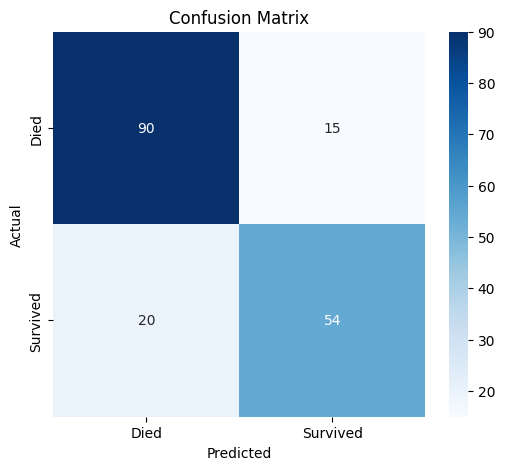

TN=90, FP=15, FN=20, TP=54
Normalized confusion matrix (by actual class):
[[0.857 0.143]
 [0.27  0.73 ]]


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the confusion matrix using the test labels and predictions
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print raw counts and a normalized matrix (by actual class) for clarity
try:
    tn, fp, fn, tp = cm.ravel()
    print(f'TN={tn}, FP={fp}, FN={fn}, TP={tp}')
except Exception:
    print('Could not unpack counts from confusion matrix; matrix shape:', cm.shape)

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix (by actual class):')
print(np.round(cm_norm, 3))

## Part 3: Precision, Recall, and F1-Score

**Concept:** From the confusion matrix, we can calculate more nuanced metrics:

*   **Precision:** Of all the times the model predicted **positive**, how often was it correct? 
    *   Formula: `TP / (TP + FP)`
    *   *Use Case:* When the cost of a **False Positive** is high. (e.g., a spam filter; you don't want to incorrectly mark an important email as spam).

*   **Recall (Sensitivity):** Of all the actual **positives**, how many did the model correctly identify?
    *   Formula: `TP / (TP + FN)`
    *   *Use Case:* When the cost of a **False Negative** is high. (e.g., a medical test for a serious disease; you don't want to miss a real case).

*   **F1-Score:** The harmonic mean of Precision and Recall. It provides a single score that balances both.

### Task 2: Generate a Classification Report

**Your Task:** Use `classification_report` from `sklearn.metrics` to get a summary of these metrics for each class.

In [12]:
from sklearn.metrics import classification_report

# Generate and print the classification report
report = classification_report(y_test, y_pred, target_names=['Died', 'Survived'])
print(report)

              precision    recall  f1-score   support

        Died       0.82      0.86      0.84       105
    Survived       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



## Part 4: Cross-Validation

**Concept:** A single train-test split can be lucky or unlucky. What if, by chance, all the "easy" examples ended up in our test set? Our accuracy score would be misleadingly high.

**Cross-Validation (CV)** solves this. It splits the data into multiple "folds" (e.g., 5 or 10). It then trains and evaluates the model multiple times, using a different fold as the test set each time. The final score is the average of the scores from all folds.

This gives a much more robust and reliable estimate of the model's true performance.

### Task 3: Perform Cross-Validation

**Your Task:** Use `cross_val_score` from `sklearn.model_selection` to perform 5-fold cross-validation on your model.

In [13]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform 5-fold cross-validation (cross_val_score handles splitting)
cv_scores = cross_val_score(model, X, y, cv=5)

# Print the scores for each fold and summary statistics
print(f"Scores for each fold: {np.round(cv_scores, 3)}")
print(f"Average CV Score: {cv_scores.mean():.2%}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.4f}")

Scores for each fold: [0.788 0.781 0.787 0.775 0.803]
Average CV Score: 78.68%
Standard Deviation of CV Scores: 0.0094


## 📝 Knowledge Check

**Instructions:** Answer the following questions in this markdown cell.

1.  **Describe a real-world scenario where you would care more about a model's Precision than its Recall.**

I would care more about precision for something like an email spam filter. If the filter marks a message as spam (positive), I want to be very sure it actually is spam so important emails don't get lost, meaning fewer false positives, even if we miss some spam (lower recall).

2.  **Describe a real-world scenario where you would care more about a model's Recall than its Precision.**

Recall is more important for medical screening (testing for a serious disease). Missing a real case (false negative) can be dangerous, so we'd accept more false alarms (lower precision) to make sure we catch as many true cases as possible.

3.  **Why is a cross-validation score generally more trustworthy than a score from a single train-test split?**

Cross-validation averages performance across multiple different train/test splits, so the results isn't just from one lucky or unlucky split. It gives a better estimate of how the model will do on new data and also shows how much the score varies between folds, which helps detect overfitting or unstable models.